# HTSI Tear-Down
A stripped down simulation to show how the thing works

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

#from astropy.io import fits
#import astropy.units as u
#from specutils.spectra import Spectrum1D
#from skimage import transform
#from skimage import img_as_float64

import napari

## Create the set of postive and negative Hadamard masks

In [8]:
n=8
hadamard=sp.linalg.hadamard(n)
for i in range(n):
    for j in range(n):
        if hadamard[i,j]==-1:
            hadamard[i,j]=0
            
#plt.imshow(hadamard,cmap='gray')
#plt.show()

p_masks=np.empty((n,n,n))
n_masks=np.empty((n,n,n))

for i in range(n):
    for j in range(n):
        p_masks[i,:,j]=hadamard[j,:]
        n_masks[i,:,j]=1-hadamard[j,:]

In [9]:
viewer = napari.view_image(p_masks)

## Create some simple input scenes

In [4]:
# Monospectral base scenes
dot_grid=np.zeros((n,n))
for i in range(n):
    dot_grid[int(n/2):int(n/2)+1,int(n/2):int(n/2)+1]=1
      
### CALIBRATION GRID
cal_grid=np.zeros((n,n))
mwidth = 10

cal_grid[int(n/2)-mwidth:int(n/2)+mwidth,int(n/2)-mwidth:int(n/2)+mwidth]=1

x_offset = 10; y_offset = 10
cal_grid[x_offset-mwidth:x_offset+mwidth,y_offset-mwidth:y_offset+mwidth]=1
x_offset = 118; y_offset = 10
cal_grid[x_offset-mwidth:x_offset+mwidth,y_offset-mwidth:y_offset+mwidth]=1
x_offset = 10; y_offset = 118
cal_grid[x_offset-mwidth:x_offset+mwidth,y_offset-mwidth:y_offset+mwidth]=1
x_offset = 118; y_offset = 118
cal_grid[x_offset-mwidth:x_offset+mwidth,y_offset-mwidth:y_offset+mwidth]=1
 

### MIXED FIELD
mixed_field = np.zeros((n,n))
nebula_width = 10

x_offset = int(128/2); y_offset = int(128/2)
mixed_field[x_offset-nebula_width:x_offset+nebula_width,y_offset-nebula_width:y_offset+nebula_width]=1
mixed_field[10,10]=1
mixed_field[20,20]=1
mixed_field[30,30]=1
mixed_field[40,40]=1
mixed_field[50,50]=1
mixed_field[80,80]=1
mixed_field[90,90]=1
mixed_field[100,100]=1
mixed_field[110,110]=1
mixed_field[120,120]=1

mixed_field[30,100]=1
mixed_field[100,30]=1

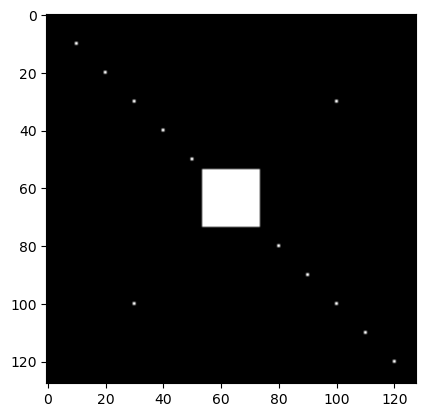

In [8]:
# PICK ONE !!!!
#scene = dot_grid
#scene = cal_grid 
scene = mixed_field 

plt.imshow(scene,cmap='gray');plt.show()

##  Apply the Hadamard masks and dispersion to the input scene

In [9]:
p_mask_scene=np.empty((n,n,n))
n_mask_scene=np.empty((n,n,n))

for i in range(n):
    p_mask_scene[:,:,i] = scene*p_masks[:,:,i]
    n_mask_scene[:,:,i] = scene*n_masks[:,:,i]

In [10]:
#Simple dispersion model 
p_mask_dispersed = np.empty((n,n,n))
n_mask_dispersed = np.empty((n,n,n))

pix_skip = -2   # how many pixels to shift the input (linear dispersion)
n_spect = 3     # how many times to shift (number of spectral data points)
for i in range(n):
    for j in range(n_spect):
        pval = 1/(j+1) # intensity of shifted value
        p_mask_dispersed[:,:,i] = p_mask_dispersed[:,:,i] + sp.ndimage.shift(p_mask_scene[:,:,i]*pval, (0,pix_skip*j))
        n_mask_dispersed[:,:,i] = n_mask_dispersed[:,:,i] + sp.ndimage.shift(n_mask_scene[:,:,i]*pval, (0,pix_skip*j))

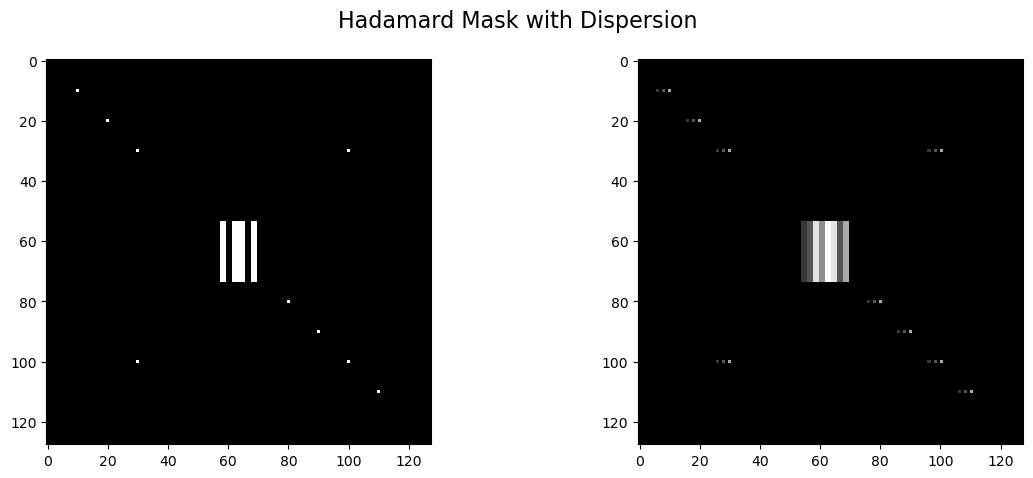

In [21]:
plot_show = 10 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
fig.suptitle('Hadamard Mask with Dispersion', fontsize=16)
ax1.imshow(p_mask_scene[:,:,plot_show],cmap='gray')
ax2.imshow(p_mask_dispersed[:,:,plot_show],cmap='gray')

In [11]:
viewer = napari.view_image(p_mask_scene)
viewer = napari.view_image(p_mask_dispersed)

In [12]:
data_cube = np.empty((n,n,n))
for i in range(n):
    data_cube[:,:,i]=p_mask_dispersed[:,:,i]-n_mask_dispersed[:,:,i]

flattened_array=data_cube.reshape(n*n,n,order='F')
print(flattened_array.shape)

(16384, 128)


In [13]:
hadamard_mult=np.matmul(flattened_array,sp.linalg.hadamard(n)/n)
reconstructed_data=hadamard_mult.reshape((n,n,n),order='F')

In [14]:
viewer = napari.view_image(reconstructed_data)

In [26]:
print(np.max(reconstructed_data))

1.0000000000000002
